# 频域特征值计算归档

<font face="微软雅黑" size=4>频域特征值:</font><br><br>
频域数据：$ f=[f_1,f_2,f_3,...f_n]$<br><br>
最大值：$f_{max}=\max(f)$<br><br>
最小值：$f_{min}=\min(f)$<br><br>
峰峰值：$f_{peak}=f_{max}-f_{min}$<br><br>
均值：$f_{mean}=\dfrac{1}{2}\sum_{i=1}^{n}f_i$<br><br>
有效值：$f_{rms}=\sqrt{\dfrac{1}{n}\sum_{i=1}^{n}f_i^2}$<br><br>
方差：$f_{var}=\dfrac{1}{n-1}\sum_{i=1}^{n}(f_i-f_{mean})^2$<br><br>
标准差：$\sigma=\sqrt{f_{var}}$

In [1]:
import json
import math
import operator as op
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib
import seaborn
from scipy.fftpack import fft,ifft

In [2]:
#信号：采样点N，采样频率fs,这里产生x轴信号
N = 1600
fs = 4000
signal_x = np.zeros(N)
for i in range(N):
    val = np.float64(np.pi)*2*i/fs
    signal_x[i] = 10+7*np.sin(180*val)+2.8*np.sin(390*val)+5.1*np.sin(600*val)

#采集器采集的信号数据
with open("waveform-320-1547623787137.json") as s:
    signal = pd.DataFrame(json.load(s))
    signal_x = signal['x']
    signal_x = signal_x.values

In [3]:
#计算频域特征值
def FZone_feature(f_data):
    f_data2 = np.power(f_data,2)
    f_max = max(f_data)
    f_min = min(f_data)
    f_peak = f_max-f_min
    f_mean = np.mean(f_data)
    f_rms = np.power(np.mean(f_data2),0.5)
    f_var = sum(np.power((f_data-f_mean),2))/(len(f_data)-1)
    f_sigma = np.power(f_var,0.5)
    F_feature = {"f_max":f_max,"f_min":f_min, "f_peak":f_peak,"f_mean":f_mean,"f_rms":f_rms,"f_var":f_var,"f_sigma":f_sigma}
    return F_feature

In [4]:
f_signal_x = fft(signal_x)
Fzone_feature = FZone_feature(f_signal_x)
print(Fzone_feature)

{'f_max': (228.73664476118907+7.383805640980455j), 'f_min': (-1648.6403261033215-659.0094092889892j), 'f_peak': (1877.3769708645107+666.3932149299696j), 'f_mean': (-2.32+1.4210854715202004e-16j), 'f_rms': (31.311590505753593-4.647453225249894e-15j), 'f_var': (975.6430769230736-8.0562892886602e-14j), 'f_sigma': (31.235285766630554-1.2896135077571365e-15j)}


# FIR 滤波归档

通过matlab的滤波器工具箱设计FIR滤波器的抽头系数，以保留振动信号的5次频设置滤波器通带Fpass和阻带Fstop频率。

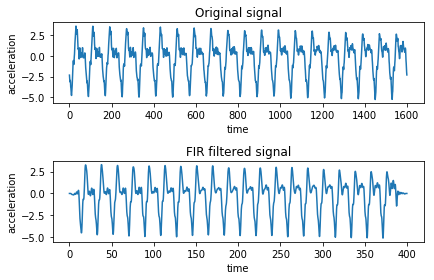

In [5]:
#读取FIR滤波器参数及信号数据
with open("firfilter.json") as f:
    firfilter = json.load(f)
with open("waveform-320-1547623787137.json") as s:
    signal = pd.DataFrame(json.load(s))
    signal_x = signal['x']
    signal_x = signal_x.values#array

#FIR滤波   
firfilter_data = scipy.signal.convolve(signal_x,firfilter['firLowpassOrder101Fs4000Fpass400Fstop500'])
axis_x = np.linspace(0,1600,num=1600)
pl.subplot(2,1,1)
pl.plot(axis_x,signal_x)
pl.title('Original signal')
pl.xlabel("time")
pl.ylabel("acceleration")
pl.tight_layout()
pl.rcParams['figure.figsize'] = (12.0,6.0)

pl.subplot(2,1,2)
axis_f = np.linspace(0,400,num=1701)
pl.plot(axis_f,firfilter_data)
pl.title('FIR filtered signal')
pl.xlabel("time")
pl.ylabel("acceleration")
pl.tight_layout()

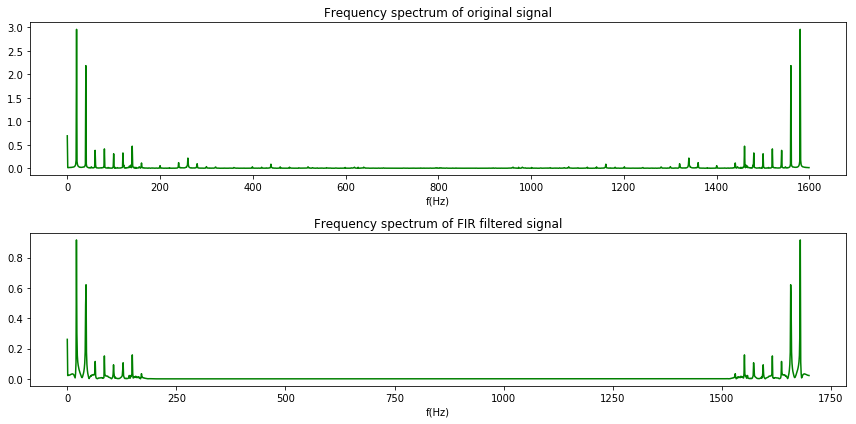

In [6]:
x = np.linspace(0,12,1600)
F_FIR = fft(firfilter_data)
yreal = F_FIR.real
yimag = F_FIR.imag

yf = abs(F_FIR)
yf1 = abs(yf)/len(firfilter_data)
yf2 = yf1[range(int(len(firfilter_data)/2))]

xf = np.arange(len(firfilter_data))
xf1 = xf
xf2 = xf[range(int(len(firfilter_data)/2))]
pl.subplot(212)
pl.plot(xf1,yf1,'g')
pl.title('Frequency spectrum of FIR filtered signal')
pl.xlabel("f(Hz)")
pl.tight_layout()

F_ori = fft(signal_x)
yyreal = F_ori.real
yyimag = F_ori.imag

yyf = abs(F_ori)
yyf1 = abs(yyf)/600#len(signal_x)
yyf2 = yyf1[range(600)]#(int(len(signal_x)/2))]

xxf = np.arange(len(signal_x))
xxf1 = xxf
# xxf2 = xxf[range(int(len(signal_x)/2))]

pl.subplot(211)
pl.plot(xxf1,yyf1,'g')
pl.title('Frequency spectrum of original signal')
pl.xlabel("f(Hz)")
pl.tight_layout()